<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_01_statistics_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reboot: Statistics from Scratch

## Phase 0 Summary: Foundations

In this phase, I rebuilt core statistical foundations with a focus on reasoning
rather than tools.

Key takeaways:
- An estimator is a rule that maps data to an estimate of an unknown quantity.
- Estimators have properties such as bias and variance that describe how they
  behave across repeated samples.
- Uncertainty is a property of the estimator, not a failure of analysis.
- Confidence intervals summarize estimator uncertainty.
- Decisions under uncertainty require thresholds informed by effect size,
  uncertainty, and asymmetric error costs, not binary significance tests.




## Problem
Refresh core statistical intuition and rebuild confidence in Python
by implementing basic statistical concepts from first principles.

## Assumptions
- Data are generated from known distributions
- Focus is on understanding, not performance
- No black-box libraries are used for core logic

## Method
Use simulations to explore sampling distributions, bias, and variance.
Implement estimators manually.

## Results

- By repeatedly sampling from the same data-generating process, I observed that
  the sampling distribution of the sample mean becomes more concentrated as the
  number of observations increases.
- This illustrates the Law of Large Numbers in practice: although individual
  observations are noisy, the sample mean converges to the true population mean
  as the number of observations grows.
- Increasing sample size reduces the variance of the estimator but does not
  eliminate bias: a deliberately biased estimator remains systematically shifted
  away from the true value even with more data.


- The variance of the sample mean decreases as sample size increases, confirming
  that more data stabilizes the estimator even though individual observations
  remain noisy.
- By resampling the observed data, the bootstrap provides an empirical
  approximation of the sampling distribution of the estimator.
- Bootstrap confidence intervals summarize uncertainty about the estimator given
  the observed data.

- Estimation uncertainty implies that decisions based on data are inherently
  probabilistic rather than deterministic.
- Decision-making requires defining thresholds that reflect risk tolerance and
  the asymmetric cost of different types of errors.
- Statistical outputs such as confidence intervals inform decisions but do not,
  by themselves, determine the optimal action.

- Phase 0 established core concepts needed to interpret statistical estimates
  rigorously.
- Regression coefficients are estimators whose interpretation depends on
  assumptions and uncertainty.

- Regression coefficients are unbiased estimators of causal effects only when
  relevant confounders are appropriately controlled for.
- Omitted variable bias persists regardless of sample size.
- Conditioning on confounders clarifies the interpretation of regression results.

- Causal structure determines whether regression coefficients can be interpreted
  causally.
- Confounders create bias when omitted, while conditioning can remove bias when
  appropriately applied.
- Statistical adjustment must follow causal reasoning rather than mechanical
  control inclusion.

- DAGs encode causal assumptions that determine valid regression specifications.
- Confounders should be controlled for, while colliders should not.
- Conditioning on the wrong variables can introduce bias even when models appear
  statistically well-specified.




## Limitations
- Only Gaussian data-generating process
- Artificially constructed biased estimator
- No real-world confounding yet

- Bootstrap assumes the observed sample is representative of the population.
- The bootstrap approximation may be unreliable for very small samples.
- All experiments rely on simulated data with known distributions.

- The decision problem is highly simplified and assumes a single effect estimate.
- Error costs are discussed qualitatively rather than modeled explicitly.
- No real operational constraints or secondary effects are included.

- No real-world confounding or selection bias is introduced yet.
- Regression is discussed conceptually without formal estimation.

- The confounder Z is fully observed in this simulation, which is rarely the
  case in real data.
- Linear relationships and additive noise are assumed.

- Causal structures are described conceptually without formal diagrams.
- All examples assume linear and additive relationships.

- DAGs are discussed conceptually without formal identification criteria.
- Examples focus on simple three-variable structures.



In [1]:
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Define a data generating process
def generate_sample(n):
    """
    Generate n observations from a standard normal distribution.
    """
    return [random.gauss(0, 1) for n in range(n)]

In [3]:
generate_sample(5)

[0.8650106813863097,
 -0.06954563277176387,
 0.35437538739402175,
 -0.9300568837137824,
 -0.21971902576462604]

In [4]:
# Define the sample mean manually
def sample_mean(x):
    """
    Compute the sample mean manually
    """
    return sum(x) / len(x)

In [5]:
sample_mean([1, 2, 3, 4])

2.5

In [6]:
# Simulate sampling distribution
def sampling_distribution(n, n_sim=1000):
    """
    Simulate the sampling distribution of the sample mean.
    """
    means=[]
    for i in range (n_sim):
        sample = generate_sample(n)
        mean = sample_mean(sample)
        means.append(sample_mean(sample))
    return means


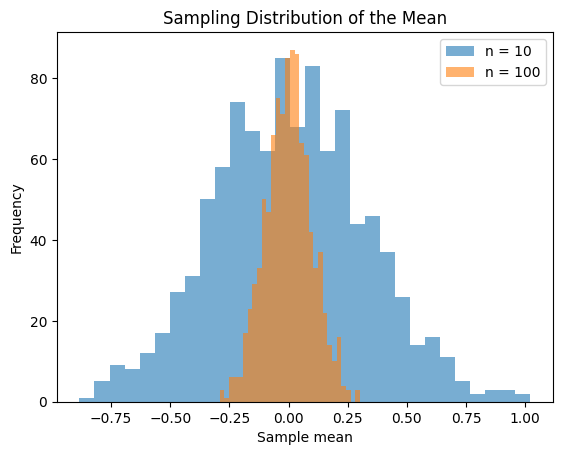

In [7]:
means_small = sampling_distribution(10)
means_large = sampling_distribution(100)

plt.hist(means_small, bins=30, alpha=0.6, label="n = 10")
plt.hist(means_large, bins=30, alpha=0.6, label="n = 100")
plt.legend()
plt.title("Sampling Distribution of the Mean")
plt.xlabel("Sample mean")
plt.ylabel("Frequency")
plt.show()

 simulate repeated samples from a fixed data-generating process and compute the sample mean for each sample. Repeating this many times allows me to observe the sampling distribution of the estimator (the sample mean).

When the sample size increases from n = 10 to n = 100, the sampling distribution of the mean becomes much more concentrated around the true population mean (0). This does not mean that the mean is computed more “accurately” in a numerical sense, but rather that the variance of the estimator decreases as sample size increases.

This illustrates the Law of Large Numbers: although individual observations are noisy, the sample mean converges to the true mean as the number of observations grows.


In [8]:
# Define a deliberately biased estimator of the mean
def biased_mean(x):
    return (sum(x) / len(x)) + 0.5

In [9]:
def evaluate_estimators(n, n_sim=1000):
    true_value = 0
    unbiased_estimates = []
    biased_estimates = []

    for _ in range(n_sim):
        sample = generate_sample(n)
        unbiased_estimates.append(sample_mean(sample))
        biased_estimates.append(biased_mean(sample))

    return unbiased_estimates, biased_estimates


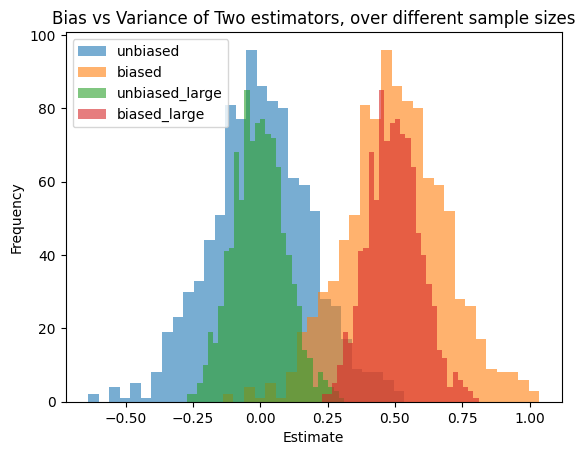

In [10]:
#viz

unbiased, biased = evaluate_estimators(n=30)
unbiased_large, biased_large = evaluate_estimators(n=100)


plt.hist(unbiased, bins=30, alpha = 0.6, label="unbiased")
plt.hist(biased, bins=30, alpha=0.6, label="biased")
plt.hist(unbiased_large, bins=30, alpha = 0.6, label="unbiased_large")
plt.hist(biased_large, bins=30, alpha=0.6, label="biased_large")
plt.legend()
plt.title("Bias vs Variance of Two estimators, over different sample sizes")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.show()

In [11]:
#Define variance manually

def sample_variance(x):
    """
    Compute the sample variance manually
    """
    mean_x = sample_mean(x)
    squared_diffs = [(xi-mean_x) **2 for xi in x]
    return sum(squared_diffs) / len(x)

In [12]:
sample_variance([1, 2, 3, 4])

1.25

In [13]:
#Variance accross repeated samples
def variance_of_estimator(n, n_sim=1000):
    estimates = []
    for _ in range(n_sim):
        sample = generate_sample(n)
        estimates.append(sample_mean(sample)) #our estimator is still the mean
    return sample_variance(estimates)

In [14]:
variance_of_estimator(10), variance_of_estimator(100) # as the number of obervation grows, variance reduces

(0.09488163082629651, 0.009647007846441503)

By repeatedly samply data and computing the sample mean, I can treat the estimates themselves as a dataset. Computing the variance of these estimates quantifies how much the estimator fluctuates across repeated samples.

As sample size increases, the variance of the sample mean decreases, confirming that more data stabilizes the estimator.



In [15]:
#implement bootstrap resampling
def bootstrap_sample(x):
    """
    Draw a bootstrap sample (same size, sampled with replacement
    """
    return [random.choice(x) for _ in range(len(x))] #resampling from the orgiinal dataset


In [16]:
#Bootstrap the sample mean
def bootstrap_means(x, n_bootstrap=1000): # we resample 1000 times
    means = []
    for _ in range(n_bootstrap):
        sample = bootstrap_sample(x)
        means.append(sample_mean(sample))
    return means # That list is the bootstrap approximation of the sampling distribution

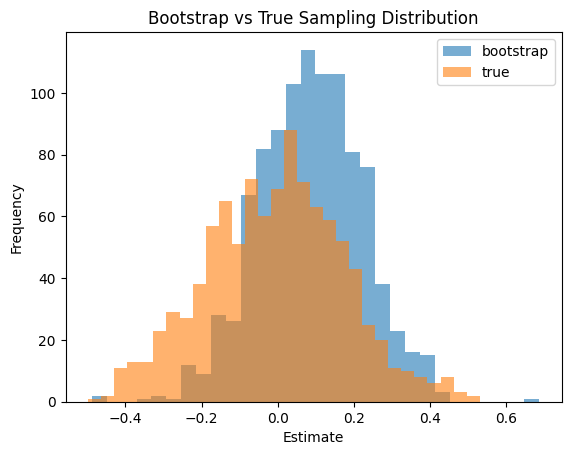

In [17]:
#Compare bootstrap vs true sampling distribution
original_sample = generate_sample(30)

bootstrap_estimates = bootstrap_means(original_sample)
true_estimates = sampling_distribution(30)

plt.hist(bootstrap_estimates, bins = 30, alpha=0.6, label="bootstrap")
plt.hist(true_estimates, bins = 30, alpha=0.6, label="true")
plt.legend()
plt.title("Bootstrap vs True Sampling Distribution")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.show()

In [18]:
#implement Confidence intervals (CI) manually
def bootstrap_ci(bootstrap_estimates, alpha=0.05): # 1-alpha is the confidence level (eg 95%)
    lower = sorted(bootstrap_estimates[int(alpha/2)*len(bootstrap_estimates)])
    upper = sorted(bootstrap_estimates[int(1-alpha/2)*len(bootstrap_estimates)])
    return lower, upper



In [19]:
#bootstrap_ci(bootstrap_estimates) #issue with float

## From estimation to decision-making

So far, I focused on estimating quantities and understanding uncertainty.
In practice, estimates are used to make decisions under uncertainty, where
different errors have different costs.

Statistical outputs should therefore be interpreted in the context of decisions,
not as binary accept/reject tests.

### Decision problem

Assume I am deciding whether a change improves an outcome.
- If the true effect is positive, I want to act.
- If the true effect is negative or zero, I do not want to act.

My estimate is uncertain, so I must decide based on an estimate and its
uncertainty rather than the true effect.


In [20]:
#Simulate an estimated effect
def simulate_estimated_effect(true_effect, n=30, noise_std=1.0):
    """
    Simulate an estimated effect as the true effect + sime noise
    """
    noise = random.gauss(0, noise_std / math.sqrt(n))
    return true_effect + noise

In [21]:
def simulate_estimates(true_effect, n_sim=1000):
    return [simulate_estimated_effect(true_effect) for _ in range(n_sim)]

In [22]:
estimates = simulate_estimates(true_effect=0.2)

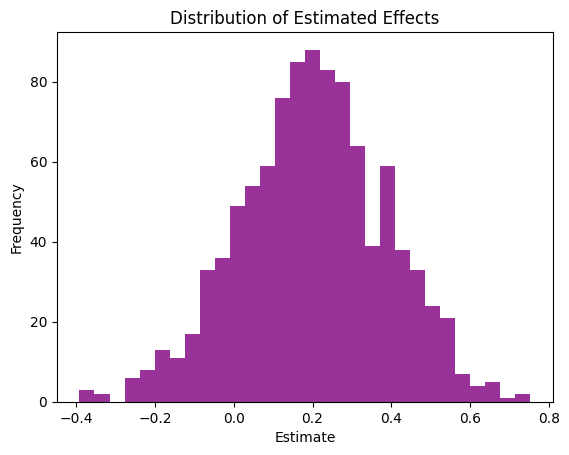

In [23]:
#visualise uncertainty
plt.hist(estimates, bins=30, alpha=0.8, color='purple')
plt.title("Distribution of Estimated Effects")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.show()

we only want to act if the effect is positive, but some estimates are negative
reality is uncertain, even if the true effect is positive

#Decisions are thresholds not tests

###A simple decision rule is:
- Act if the estimated esffect is above a chosen threshold
- Do not act otherwise

The threshol reflects risk tolerance and the relative cost of mistakes

In [24]:
#Simulate decisions under uncertainty
def decision_outcomes(estimates, threshold=0):
    decisions = []
    for est in estimates:
        decisions.append(est > threshold) #True, False
    return decisions

In [25]:
decisions = decision_outcomes(estimates, threshold=0)
sum(decisions) / len(decisions) #fraction of times we would act (%)


0.861

###Interpretation

Even when the true underlying effect is positive, estimation uncertainty can cause some estimated effects to fall below zero. As a result, any binary decision rule based on a fixed threshold will inevitably produce both false negatives (failing to act when the effect is truly positive) and false positives (acting when the effect is not truly positive).

Therefore, selecting a decision threshold is not purely a statistical exercise. It requires weighing the cost of acting unnecessarily against the cost of missing a genuinely beneficial effect. The appropriate threshold depends on these relative costs and the decision context, not just on statistical significance alone.

### Why statistical significance is insufficient

A statistically significant result does not automatically imply a good decision,
and a non-significant result does not automatically imply inaction.

Decisions should be based on estimated effect sizes, uncertainty, and the costs
of different types of errors, rather than on arbitrary significance thresholds.



## Transition to Applied Statistics

With the foundations in place, the next step is to apply these concepts to
realistic analytical tools such as regression. The focus will shift from
re-deriving concepts to interpreting estimates, understanding assumptions, and
using statistical outputs to support decisions.


## Regression as an estimator

A regression coefficient is an estimator of a conditional expectation.
Like any estimator, it has bias, variance, and uncertainty, and its interpretation
depends on the assumptions under which it is identified.

In applied work, regression is not primarily a prediction tool, but a way to
summarize conditional relationships that can inform decisions when assumptions
are carefully considered.


## Common regression pitfalls

- Regression coefficients are not automatically causal effects.
- Statistical significance of a coefficient does not imply practical relevance.
- Adding more controls does not necessarily reduce bias.
- A well-fit model can still support a poor decision if uncertainty and costs
  are ignored.


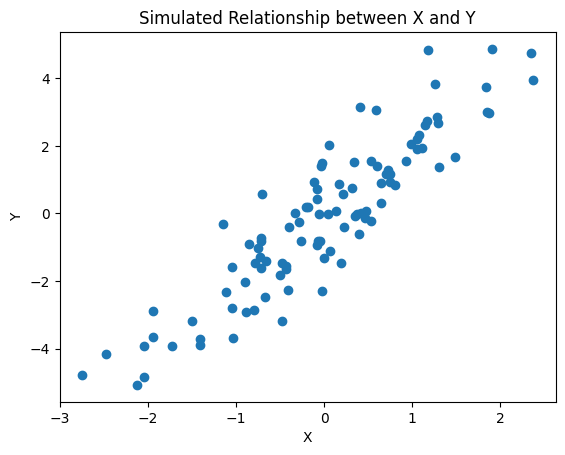

In [26]:
## Warm up
def simulate_relationship(x, beta, noise_std=1.0):
    noise = random.gauss(0, noise_std)
    return beta * x + noise

xs = [random.gauss(0, 1) for _ in range(100)]
ys = [simulate_relationship(x, beta=2.0) for x in xs]

plt.scatter(xs, ys)
plt.title("Simulated Relationship between X and Y")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Interpretation

The relationship between X and Y is noisy, but the conditional expectation of Y increases with X. A regression estimator would summarize this relationship, but the usefulness of the estimate depends on how well the assumptions match reality

In [27]:
import numpy as np
import statsmodels.api as sm

In [28]:
#Generate data that is meant for regression to work perfectly there
#X is exogenous
#The true relationship is linear
#There is no confounding
#Noise is symmetric and unbiased
#The model is correctly specified

np.random.seed(42) #freezes the random output; we want this to be reproducible

n = 2000 # fixes the sample size
X = np.random.normal(0, 1, n) # Generates 200 draws from a standard normal distribution; X is the independant variable, mean = 0 variance =1
noise = np.random.normal(0, 1, n) #This represents everything affecting Y that is not X (Measurement error, Unobserved factors, Random shocks)
# Mean = 0 → noise does not bias the relationship. Independent of X → no confounding

Y = 2 * X + noise #2 is the true causal effect, Noise makes individual observations deviate from the line

In [29]:
#Fit the regression
X_with_const = sm.add_constant(X)
model = sm.OLS(Y, X_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     7589.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:05:18   Log-Likelihood:                -2847.7
No. Observations:                2000   AIC:                             5699.
Df Residuals:                    1998   BIC:                             5711.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.023     -0.250      0.803      -0.050       0.039
x1             1.9819      0.023     87.115      0.000       1.937       2.027
==============================================================================
Omnibus:                        0.366   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.418
Skew:                           0.027   Prob(JB):                        0.811
Kurtosis:                       2.953   Cond. No.                         1.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##Interpretation
- The difference between 1.95 and 2 is sampling noise
- with.  more data, the estimate would converge around 2 (it does, when i increase n)
- on average, across many realizations, Y increases by about 1.95 when X increases by 1

- The estimated effect pof X on Y is about 1.95, with uncertainty reflecting sampling variability

### Interpretation of the regression coefficient

The regression coefficient on X estimates the average change in Y associated with a one-unit increase in X. In this simulated setting, where X is exogenous and the model is correctly specified, this estimate recovers the true underlying
relationship up to sampling variability.

The difference between the estimated coefficient and the true value reflects
estimation uncertainty rather than systematic bias.


In [30]:
# Define a new data generating process closer to real world ops data, where we introduce Z that also affects Y but is also correlated with X
np.random.seed(42)

n = 200

#Unobserved confounder
Z = np.random.normal(0, 1, n)

#X now depends on Z
X = Z + np.random.normal(0, 1, n)

#Y depends on both X and Z
Y = 2 * X + 3 * Z + np.random.normal(0, 1, n)


### regression of Y on X cannot distinguish effect of Xm effect of Z leaking through X --> this is confounding

In [31]:
#Fit the regression
X_with_const = sm.add_constant(X)
model = sm.OLS(Y, X_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1011.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           9.91e-80
Time:                        09:05:18   Log-Likelihood:                -431.68
No. Observations:                 200   AIC:                             867.4
Df Residuals:                     198   BIC:                             874.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2685      0.149     -1.803      0.073      -0.562       0.025
x1             3.3426      0.105     31.798      0.000       3.135       3.550
==============================================================================
Omnibus:                        0.736   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.655
Skew:                           0.140   Prob(JB):                        0.721
Kurtosis:                       2.989   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Omitted variable bias

Now the estimated coefficient on X is really far from true value (2), it says 3.5

In this setting, the regression coefficient on X no longer estimates the true
effect of X on Y. Because Z affects both X and Y and is omitted from the model,
the coefficient on X captures both the direct effect of X and part of the effect
of Z.

The resulting bias does not disappear with more data, as it is caused by
misspecification rather than sampling variability.

This is about bias, not variance; in real life, Z is often unobserved; you must reason about its existence, not just fit the models



In [32]:
#including the omitted variable
#conditioning: Z is held fixed, X varies “cleanly”
#The estimator targets the right quantity

import statsmodels.api as sm

X_design = sm.add_constant(np.column_stack([X, Z]))
model = sm.OLS(Y, X_design)
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2637.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          6.48e-143
Time:                        09:05:18   Log-Likelihood:                -280.23
No. Observations:                 200   AIC:                             566.5
Df Residuals:                     197   BIC:                             576.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0897      0.070     -1.275      0.204      -0.228       0.049
x1             1.9798      0.071     27.722      0.000       1.839       2.121
x2             2.8789      0.109     26.434      0.000       2.664       3.094
==============================================================================
Omnibus:                        1.716   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.565
Skew:                           0.217   Prob(JB):                        0.457
Kurtosis:                       3.012   Cond. No.                         2.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conditioning on the omitted variable

When Z is included in the regression, the coefficient on X recovers the true
effect of X on Y. By conditioning on Z, the model separates the variation in X
that is independent of Z from the variation that is driven by Z.

This illustrates that regression estimates causal effects only when all relevant
confounders are appropriately controlled for.


### Bias vs variance revisited

Omitted variable bias is a form of systematic error caused by model
misspecification. Unlike variance, it does not disappear with more data.

Correcting bias requires changing the model or assumptions, not increasing
sample size.


### Implications for applied work

In real operational datasets, confounders like Z are often unobserved or only
partially measured. As a result, regression coefficients must be interpreted
with caution, and causal assumptions should be stated explicitly rather than
implicitly assumed.


## Why causal structure matters

Regression results depend not only on data, but on how variables are causally
related. Causal diagrams help reason about which variables must be controlled
for, which must not, and why certain regressions are biased.


### Simple causal structure

X → Y

X directly affects Y.
There are no other variables influencing both X and Y.
In this setting, regressing Y on X recovers the causal effect of X on Y.


### Confounding structure

Z → X → Y

Z → Y

Z is a confounder because it affects both X and Y.
If Z is omitted from the regression, the coefficient on X mixes the effect of X
with the effect of Z.


### Conditioning on a confounder

Conditioning on Z means comparing units with the same value of Z and asking how Y
changes with X within those groups.

By holding Z fixed, the variation in X used to estimate its effect is no longer
driven by Z, allowing the regression coefficient on X to recover the causal
effect.


### Why not all controls are good controls

Not all variables should be controlled for.
Controlling for variables that lie on the causal path from X to Y, or that are
colliders, can introduce bias rather than remove it.

Causal structure determines which variables are appropriate controls, not their
statistical significance.


### Causal reasoning checklist

Before running a regression, ask:
- What is the causal question?
- Which variables affect both X and Y?
- Which variables are consequences of X?
- Which variables are affected by both X and Y?

Regression coefficients should only be interpreted causally if the conditioning
set aligns with the causal structure.


### Implications for applied analytics

In operational settings, many confounders are unobserved or partially measured.
Causal reasoning helps identify when regression results are likely biased and
guides the choice of robustness checks, sensitivity analyses, or alternative
designs.


## Directed Acyclic Graphs (DAGs)

A Directed Acyclic Graph (DAG) is a visual representation of causal assumptions.
Nodes represent variables, and arrows represent direct causal effects.

DAGs do not encode statistical relationships; they encode beliefs about how the
world works. Regression results can only be interpreted causally relative to a
DAG.


### Three fundamental causal structures

1. Chain: X → Z → Y  
2. Fork (confounder): Z → X and Z → Y  
3. Collider: X → Z ← Y  

Each structure behaves differently under conditioning.


### Fork (confounder)

Z → X  
Z → Y  

Z creates a fallacious association between X and Y.
Conditioning on Z blocks the backdoor path and removes bias.


### Collider structure

X → Z ← Y  

Z is a collider because it is caused by both X and Y.
Without conditioning, X and Y are independent.
Conditioning on Z creates a fallacious association between X and Y.


### Collider intuition: selection bias example

Suppose:
- X = skill
- Y = luck
- Z = being hired

Skill and luck both increase the chance of being hired.
Among all applicants, skill and luck are independent.
Among hired people (conditioning on Z), skill and luck become negatively related.

Conditioning on a collider creates bias.


### Why controlling for everything is dangerous

Including a variable in a regression is equivalent to conditioning on it.
If that variable is a collider or lies on the causal path, conditioning introduces
bias rather than removing it.

Statistical significance and model fit do not protect against this kind of bias.


### Practical control-variable rule

Control for:
- Variables that cause both X and Y (confounders)

Do not control for:
- Variables caused by X
- Variables caused by Y
- Variables caused by both X and Y (colliders)

Causal reasoning, not statistical heuristics, determines the correct controls.


In [33]:
#simulate a collider structure
np.random.seed(0)

n = 500
X = np.random.normal(0, 1, n)
Y = np.random.normal(0, 1, n)
Z = X + Y + np.random.normal(0, 0.1, n)

np.corrcoef(X, Y)[0, 1], np.corrcoef(X, Z)[0, 1], np.corrcoef(Y, Z)[0, 1]


(np.float64(-0.04079647122292947),
 np.float64(0.6981324172878323),
 np.float64(0.6834089467104297))

In [34]:
mask = Z > np.percentile(Z, 75) #mimick a filter post treatment (select only high values of Z)

np.corrcoef(X[mask], Y[mask])[0, 1] #now it looks like X and Y are correlated, even though we know that they are not, by construction --> bias introduced by us controlling for the wrong variable, the collider


np.float64(-0.6026099866120166)

# Backdoor criterion


In [35]:
#simulate a confounded world
np.random.seed(1)
n = 500

#Confounder:
Z = np.random.normal(0, 1, n) # --> affects both X and Y

#Treatment
X = 1.5 * Z + np.random.normal(0, 1, n)

#Outcome
Y = 2.0 * X + 3.0 * Z + np.random.normal(0, 1, n)

# The backdoor path is open X <-- Z --> Y
# True causal effect of X on Y = 2.0

In [38]:
#Regression #1: no adjustment
X1 = sm.add_constant(X)
res1 = sm.OLS(Y, X1).fit()
res1.params

#result is far from 2.0

array([0.09138593, 3.40609307])

In [41]:
#Regression #2: correct adjustment
X2 = sm.add_constant(np.column_stack([X, Z]))
res2 = sm.OLS(Y, X2).fit()
res2.params

#result: coefficient is close to 2; backdoor criterion in action

array([0.07616095, 2.0236437 , 2.98435111])

In [42]:
#Regression 3: bad adjustment (collider)
C = X + Y + np.random.normal(0, 1, n)

X3 = sm.add_constant(np.column_stack([X, C]))
res3 = sm.OLS(Y, X3).fit()
res3.params

#result: X3 is wrong again (0.01); we introduced a bias by adjusting the wrong variable (collider)

array([0.04059645, 0.01346148, 0.76665627])

### Empirical demonstration of the backdoor criterion
 When the confounder Z is omitted, the regression coefficient on X is biased.
 Conditioning on Z blocks the backdoor path and recovers the true causal effect.
 Conditioning on a collider re-opens a non-causal path and introduces bias, even though model fit may improve



### Deep Dive

If we rerun for n in [100, 1000, 10000], we see that Bias persists and becomes more certain with more dta when identification is wrong

If we rerun fo increased noise vs signal Y = 2.0 * X + 3.0 * Z + np.random.normal(0, 5, n), we observe that variance increases, confidence intervals widen, but bias behaviour is unchanged. Variance is about uncertainty, bias is about structure

In [44]:
# Create a richer graph in code
W = np.random.normal(0, 1, n)
Z2 = 0.5 * Z + np.random.normal(0, 1, n)

Y = 2.0 * X + 3.0 * Z + np.random.normal(0, 1, n)

In [48]:
#Regression #1: control for X only
X1 = sm.add_constant(X)
res1 = sm.OLS(Y, X1).fit()
print(res1.summary())

#result is far from 2.0 (3.4)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     5351.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          1.48e-268
Time:                        10:08:06   Log-Likelihood:                -1025.3
No. Observations:                 500   AIC:                             2055.
Df Residuals:                     498   BIC:                             2063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0460      0.084      0.545      0.5

In [49]:
#Regression #2: control for X + W
X2 = sm.add_constant(np.column_stack([X, W]))
res2 = sm.OLS(Y, X2).fit()
print(res2.summary())

#result: controlling for sth that is not on the path (W) doesnt change the coeff on X, and is still wrong

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     2676.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          8.42e-267
Time:                        10:08:48   Log-Likelihood:                -1024.8
No. Observations:                 500   AIC:                             2056.
Df Residuals:                     497   BIC:                             2068.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0470      0.084      0.557      0.5

In [50]:
#Regression #2: control for X + Z2 (Z2 is a descendant of Z, the confounder, but is not on the causal path to Y)
X2 = sm.add_constant(np.column_stack([X, Z2]))
res2 = sm.OLS(Y, X2).fit()
print(res2.summary())

#result: controlling for sth that is not on the path (Z2), even if a descendant of the confounder doesnt change the coeff on X, and is still wrong

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     2953.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          1.49e-276
Time:                        10:11:16   Log-Likelihood:                -1002.2
No. Observations:                 500   AIC:                             2010.
Df Residuals:                     497   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0614      0.081      0.761      0.4

In [51]:
#Regression #2: control for X + Z + W (controlling both for the confounder and for sth that is not on the causal path)
X2 = sm.add_constant(np.column_stack([X, Z, W]))
res2 = sm.OLS(Y, X2).fit()
print(res2.summary())

#result: controlling for the confounder + for sth random gives correct results. It's just useless to control for W

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     6450.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:12:37   Log-Likelihood:                -718.87
No. Observations:                 500   AIC:                             1446.
Df Residuals:                     496   BIC:                             1463.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0314      0.046      0.684      0.4

### REAL EXAMPLE

- X = compensation issued
- Y = 28-day retention
- Z = order issue severity
- C = basket value



1.   severity --> compensation --> retention
2.   severity --> retention
3.   compensation --> basket value <-- retention


The backdoor path is open: severity is the confounder
Basket Value is influenced by both X and Y, it's the collider and should not be controlled for


